#Fall Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Data Preprocessing and Feature Engineering
def preprocess_data(data_file):
    df = pd.read_csv(data_file)

    # Check if columns exist, if not, create with default value 0
    required_features = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z',
                         'emg_signal', 'heart_rate', 'spo2', 'ecg_signal']
    for feature in required_features:
        if feature not in df.columns:
            df[feature] = 0  # or any other default value

    features = required_features  # Using the validated list

    df['acc_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    df['gyro_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

    # Create sequences of 5 time steps
    X_sequences = []
    y_sequences = []
    sequence_length = 5

    for i in range(len(df) - sequence_length + 1):
        X_seq = df[features + ['acc_magnitude', 'gyro_magnitude']].iloc[i:i+sequence_length].values
        y_seq = df['stroke_label'].iloc[i+sequence_length-1]
        X_sequences.append(X_seq)
        y_sequences.append(y_seq)

    X = np.array(X_sequences)
    y = pd.Series(y_sequences).map({-1: 0, 0: 0, 1: 1}).values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    return X_scaled, y, scaler, features + ['acc_magnitude', 'gyro_magnitude']

# 2. Hybrid Model with Improvements
def create_hybrid_model(input_shape):
    lstm_input = layers.Input(shape=(5, input_shape[-1]))
    lstm = layers.LSTM(128, return_sequences=True, dropout=0.2)(lstm_input)  # Increased units, added dropout
    lstm = layers.LSTM(64, dropout=0.2)(lstm)

    dense_input = layers.Input(shape=(input_shape[-1],))
    dense = layers.Dense(128, activation='relu')(dense_input)  # Increased capacity
    dense = layers.Dropout(0.2)(dense)
    dense = layers.Dense(64, activation='relu')(dense)

    combined = layers.concatenate([lstm, dense])
    output = layers.Dense(1, activation='sigmoid')(combined)

    model = models.Model(inputs=[lstm_input, dense_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_dense = X_train[:, -1, :]
    X_test_dense = X_test[:, -1, :]

    # Gradient Boosting with tuned parameters
    gb_model = GradientBoostingClassifier(
        n_estimators=300,  # Increased estimators
        learning_rate=0.05,  # Lower learning rate for better convergence
        max_depth=7,  # Increased depth
        random_state=42
    )
    gb_model.fit(X_train[:, -1, :], y_train)

    # Hybrid model with early stopping
    hybrid_model = create_hybrid_model(X_train.shape)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    hybrid_model.fit(
        [X_train, X_train_dense], y_train,
        epochs=100,  # Increased epochs
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate
    gb_pred = gb_model.predict(X_test[:, -1, :])
    hybrid_pred = (hybrid_model.predict([X_test, X_test_dense], verbose=0) > 0.5).astype(int)

    print("Gradient Boosting Results:")
    print(classification_report(y_test, gb_pred))
    print("\nHybrid Model Results:")
    print(classification_report(y_test, hybrid_pred.ravel()))

    return gb_model, hybrid_model

# 3. Fake Fall Detection with Adjusted Threshold
def detect_fake_fall(gb_model, hybrid_model, X, threshold=0.75):  # Lowered threshold
    X_dense = X[:, -1, :]

    gb_probs = gb_model.predict_proba(X_dense)[:, 1]
    hybrid_probs = hybrid_model.predict([X, X_dense], verbose=0).ravel()

    # Weighted ensemble (favoring hybrid model)
    ensemble_probs = 0.4 * gb_probs + 0.6 * hybrid_probs  # Adjusted weights
    predictions = (ensemble_probs > 0.5).astype(int)

    fake_falls = []
    for i, (prob, pred) in enumerate(zip(ensemble_probs, predictions)):
        if pred == 1 and prob < threshold:
            fake_falls.append(i)

    return predictions, fake_falls, ensemble_probs

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    X_scaled, y, scaler, feature_cols = preprocess_data('/content/drive/MyDrive/Hackathon2.0/synthetic_fall_data.csv')

    # Train models
    gb_model, hybrid_model = train_model(X_scaled, y)

    # Save models
    joblib.dump(gb_model, 'gb_fall_model.pkl')
    hybrid_model.save('hybrid_fall_model.h5')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(feature_cols, 'feature_cols.pkl')

    # Test fake fall detection
    predictions, fake_falls, probs = detect_fake_fall(gb_model, hybrid_model, X_scaled[:100])
    print(f"Detected {len(fake_falls)} potential fake falls in first 100 samples")

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9477 - loss: 0.1781 - precision: 0.8912 - recall: 0.9950 - val_accuracy: 1.0000 - val_loss: 7.3648e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 1.0000 - loss: 6.2085e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.1092e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 1.0000 - loss: 2.1646e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 8.9056e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 1.2662e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 6.8832e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 1.0000 - loss: 5.8748e-05 - precision: 1.0000 - recall: 1

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1386
           1       1.00      1.00      1.00       614

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Hybrid Model Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1386
           1       1.00      1.00      1.00       614

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Detected 0 potential fake falls in first 100 samples


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Load trained models and scaler
def load_models():
    try:
        gb_model = joblib.load('/content/drive/MyDrive/Hackathon2.0/gb_fall_model (4).pkl')
        hybrid_model = tf.keras.models.load_model('/content/drive/MyDrive/Hackathon2.0/hybrid_fall_model (3).h5')
        scaler = joblib.load('/content/drive/MyDrive/Hackathon2.0/scaler (3).pkl')
        feature_cols = joblib.load('/content/drive/MyDrive/Hackathon2.0/feature_cols (4).pkl')
        return gb_model, hybrid_model, scaler, feature_cols
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Model file missing: {e}. Please train the models first.")

# Process custom input
def process_custom_input(custom_data, scaler, feature_cols, buffer=None):
    if buffer is None:
        buffer = []

    # Create data dictionary from input
    data_dict = {
        'accel_x': custom_data['accel_x'], 'accel_y': custom_data['accel_y'], 'accel_z': custom_data['accel_z'],
        'gyro_x': custom_data['gyro_x'], 'gyro_y': custom_data['gyro_y'], 'gyro_z': custom_data['gyro_z'],
        'emg_signal': custom_data['emg_signal'], 'heart_rate': custom_data['heart_rate'],
        'spo2': custom_data['spo2'], 'ecg_signal': custom_data['ecg_signal']
    }
    buffer.append(list(data_dict.values()))

    # Maintain 5-sample buffer
    if len(buffer) < 5:
        return None, None, buffer, "Collecting data (need 5 samples)"

    if len(buffer) > 5:
        buffer.pop(0)  # Remove oldest sample

    # Create DataFrame and compute magnitudes
    df = pd.DataFrame(buffer, columns=feature_cols[:10])
    df['acc_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    df['gyro_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

    # Prepare sequence for prediction
    X = np.array([df[feature_cols].values])
    X_scaled = scaler.transform(X.reshape(-1, len(feature_cols))).reshape(1, 5, len(feature_cols))

    # Diagnostic prints
    print(f"\nBuffer Content (last sample):\n{df.iloc[-1]}")
    print(f"Scaled Input Shape: {X_scaled.shape}")
    print(f"Scaled Sample (last timestep): {X_scaled[0, -1, :]}")

    return X_scaled, df.iloc[-1][feature_cols].values, buffer, "Data processed"

# Test prediction with weighted ensemble
def test_prediction(gb_model, hybrid_model, X_scaled, X_dense, threshold=0.75):
    gb_probs = gb_model.predict_proba([X_dense])[0][1]
    hybrid_probs = hybrid_model.predict([X_scaled, X_scaled[:, -1, :]], verbose=0)[0][0]

    # Print individual probabilities for debugging
    print(f"GB Probability: {gb_probs:.4f}")
    print(f"Hybrid Probability: {hybrid_probs:.4f}")

    # Weighted ensemble: 40% GB, 60% Hybrid
    ensemble_prob = 0.4 * gb_probs + 0.6 * hybrid_probs
    prediction = 1 if ensemble_prob > 0.5 else 0

    is_fake = False
    if prediction == 1 and ensemble_prob < threshold:
        is_fake = True

    result = {
        'prediction': 'Fall Detected' if prediction == 1 else 'No Fall',
        'is_fake': 'Possible Fake Fall' if is_fake else 'Confirmed' if prediction == 1 else 'N/A',
        'confidence': ensemble_prob
    }
    return result

# Interactive testing function
def interactive_test():
    gb_model, hybrid_model, scaler, feature_cols = load_models()
    buffer = []

    print("Enter sensor values to test fall detection (5 samples needed for prediction)")
    print("Expected format: accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, emg_signal, heart_rate, spo2, ecg_signal")

    while True:
        try:
            user_input = input("\nEnter values (comma-separated) or 'quit' to exit: ")
            if user_input.lower() == 'quit':
                break

            values = [float(x.strip()) for x in user_input.split(',')]
            if len(values) != 10:
                print("Error: Please provide exactly 10 values")
                continue

            custom_data = {
                'accel_x': values[0], 'accel_y': values[1], 'accel_z': values[2],
                'gyro_x': values[3], 'gyro_y': values[4], 'gyro_z': values[5],
                'emg_signal': values[6], 'heart_rate': values[7], 'spo2': values[8], 'ecg_signal': values[9]
            }

            X_scaled, X_dense, buffer, status = process_custom_input(custom_data, scaler, feature_cols, buffer)

            print(f"Status: {status}")
            print(f"Buffer size: {len(buffer)}")

            if X_scaled is not None:
                result = test_prediction(gb_model, hybrid_model, X_scaled, X_dense)
                print("\nResults:")
                print(f"Prediction: {result['prediction']}")
                print(f"Fall Status: {result['is_fake']}")
                print(f"Confidence: {result['confidence']:.4f}")

                if result['prediction'] == 'Fall Detected' and result['is_fake'] == 'Confirmed':
                    print("SOS would be sent to emergency contacts!")

        except ValueError as e:
            print(f"Error: Please enter valid numeric values ({e})")
        except Exception as e:
            print(f"Error occurred: {e}")

if __name__ == "__main__":
    try:
        interactive_test()
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

Enter sensor values to test fall detection (5 samples needed for prediction)
Expected format: accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, emg_signal, heart_rate, spo2, ecg_signal

Enter values (comma-separated) or 'quit' to exit: 0.2, -0.5, 0.8, 150, -100, 50, 85, 95, 2.5, 0.1
Status: Collecting data (need 5 samples)
Buffer size: 1

Enter values (comma-separated) or 'quit' to exit: 0.2, -0.5, 0.8, 150, -100, 50, 85, 95, 2.5, 0.1
Status: Collecting data (need 5 samples)
Buffer size: 2

Enter values (comma-separated) or 'quit' to exit: 0.2, -0.5, 0.8, 150, -100, 50, 85, 95, 2.5, 0.1
Status: Collecting data (need 5 samples)
Buffer size: 3

Enter values (comma-separated) or 'quit' to exit: 0.2, -0.5, 0.8, 150, -100, 50, 85, 95, 2.5, 0.1
Status: Collecting data (need 5 samples)
Buffer size: 4

Enter values (comma-separated) or 'quit' to exit: 0.2, -0.5, 0.8, 150, -100, 50, 85, 95, 2.5, 0.1

Buffer Content (last sample):
accel_x             0.200000
accel_y            -0.500000
accel_

# Stroke Detection

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import time

# Step 1: Simulate 100 Rows for Training
np.random.seed(42)
n_rows = 100
data = {
    'accel_x': np.random.uniform(-2, 2, n_rows),
    'accel_y': np.random.uniform(-2, 2, n_rows),
    'accel_z': np.random.uniform(-2, 2, n_rows),
    'gyro_x': np.random.uniform(-250, 250, n_rows),
    'gyro_y': np.random.uniform(-250, 250, n_rows),
    'gyro_z': np.random.uniform(-250, 250, n_rows),
    'heart_rate': np.random.uniform(60, 100, n_rows),
    'spo2': np.random.uniform(90, 100, n_rows),
    'emg_signal': np.random.uniform(0.5, 3, n_rows),
    'ecg_signal': np.random.uniform(-1, 1, n_rows),
    'stroke_label': np.concatenate([np.zeros(33), np.ones(33), -np.ones(34)])
}
df_sample = pd.DataFrame(data)

for i in range(n_rows):
    label = df_sample.loc[i, 'stroke_label']
    if label == 1:  # True Stroke
        df_sample.loc[i, 'accel_x'] += np.random.uniform(1, 3)
        df_sample.loc[i, 'gyro_x'] += np.random.uniform(100, 200)
        df_sample.loc[i, 'heart_rate'] = np.random.uniform(100, 140)
        df_sample.loc[i, 'spo2'] = np.random.uniform(85, 92)
        df_sample.loc[i, 'emg_signal'] = np.random.uniform(3, 5)
        df_sample.loc[i, 'ecg_signal'] = np.random.uniform(-2, 2)
    elif label == -1:  # Fake Stroke
        df_sample.loc[i, 'accel_x'] += np.random.uniform(-0.5, 0.5)
        df_sample.loc[i, 'gyro_x'] += np.random.uniform(-50, 50)
        df_sample.loc[i, 'heart_rate'] = np.random.uniform(60, 120)
        df_sample.loc[i, 'spo2'] = np.random.uniform(88, 98)
        df_sample.loc[i, 'emg_signal'] = np.random.uniform(0.2, 1.5)
        df_sample.loc[i, 'ecg_signal'] = np.random.uniform(-0.5, 0.5)

df_sample = df_sample.sample(frac=1).reset_index(drop=True)
df_sample['timestamp'] = np.arange(0, n_rows / 100, 1 / 100)

# Scale to 20,000 samples
n_samples = 20000
repeat_factor = n_samples // len(df_sample) + 1
df = pd.concat([df_sample] * repeat_factor, ignore_index=True).iloc[:n_samples]

for col in df.columns[:-1]:
    df[col] += np.random.normal(0, 0.01, n_samples)

labels = np.array([0, 1, -1])
target_counts = n_samples // 3
for label in labels:
    current_count = (df['stroke_label'] == label).sum()
    if current_count < target_counts:
        to_add = target_counts - current_count
        indices = df[df['stroke_label'] != label].sample(to_add, replace=True).index
        df.loc[indices, 'stroke_label'] = label

df['timestamp'] = np.arange(0, n_samples / 100, 1 / 100)

# Step 2: Preprocessing
window_size = 500
step_size = 250

scaler = StandardScaler()
sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z',
               'heart_rate', 'spo2', 'emg_signal', 'ecg_signal']
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

def create_windows(df, window_size, step_size):
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[sensor_cols].values)
        y.append(np.bincount(window['stroke_label'].astype(int) + 1).argmax() - 1)
    return np.array(X), np.array(y)

X, y = create_windows(df, window_size, step_size)
print("Windowed data shape:", X.shape, y.shape)

y = tf.keras.utils.to_categorical(y + 1, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

def augment_data(X):
    noise = np.random.normal(0, 0.05, X.shape)
    return X + noise

X_train_aug = augment_data(X_train)

# Step 3: Model Architecture
def build_model(window_size, num_features):
    mpu_input = layers.Input(shape=(window_size, 6))
    max_input = layers.Input(shape=(window_size, 2))
    emg_input = layers.Input(shape=(window_size, 1))
    ecg_input = layers.Input(shape=(window_size, 1))

    def cnn_branch(x, filters):
        x = layers.Conv1D(filters, 5, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(filters, 5, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(2)(x)
        return x

    mpu_features = cnn_branch(mpu_input, 128)
    max_features = cnn_branch(max_input, 64)
    emg_features = cnn_branch(emg_input, 64)
    ecg_features = cnn_branch(ecg_input, 64)

    combined = layers.Concatenate()([mpu_features, max_features, emg_features, ecg_features])
    lstm_out = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(combined)
    attention = layers.Attention()([lstm_out, lstm_out])
    lstm_out = layers.LSTM(128)(attention)
    lstm_out = layers.Dropout(0.5)(lstm_out)

    dense_out = layers.Dense(256, activation='relu')(lstm_out)
    dense_out = layers.Dropout(0.4)(dense_out)
    output = layers.Dense(3, activation='softmax')(dense_out)

    model = Model(inputs=[mpu_input, max_input, emg_input, ecg_input], outputs=output)
    return model

# Prepare training inputs
X_train_mpu = X_train[:, :, :6]
X_train_max = X_train[:, :, 6:8]
X_train_emg = X_train[:, :, 8:9]
X_train_ecg = X_train[:, :, 9:10]

X_val_mpu = X_val[:, :, :6]
X_val_max = X_val[:, :, 6:8]
X_val_emg = X_val[:, :, 8:9]
X_val_ecg = X_val[:, :, 9:10]

X_test_mpu = X_test[:, :, :6]
X_test_max = X_test[:, :, 6:8]
X_test_emg = X_test[:, :, 8:9]
X_test_ecg = X_test[:, :, 9:10]

# Train classifier
model = build_model(window_size, 10)
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)),
                                                  y=np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    [X_train_mpu, X_train_max, X_train_emg, X_train_ecg], y_train,
    validation_data=([X_val_mpu, X_val_max, X_val_emg, X_val_ecg], y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(
    [X_test_mpu, X_test_max, X_test_emg, X_test_ecg], y_test, verbose=0
)
print(f"Test Accuracy on Simulated Data: {test_accuracy:.4f}")

# Step 4: Autoencoder for Anomaly Detection
def build_autoencoder(window_size, num_features):
    input_layer = layers.Input(shape=(window_size, num_features))
    x = layers.LSTM(128, return_sequences=True)(input_layer)
    x = layers.LSTM(64)(x)
    x = layers.RepeatVector(window_size)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    output_layer = layers.TimeDistributed(layers.Dense(num_features))(x)
    return Model(input_layer, output_layer)

X_train_normal = X_train[np.argmax(y_train, axis=1) == 0]
autoencoder = build_autoencoder(window_size, 10)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_normal, X_train_normal, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Step 5: Function to Process User Sensor Input
def process_user_input(scaler, model, autoencoder, window_size):
    print("\n=== Real-Time Stroke Detection ===")
    print("Enter sensor data (accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, heart_rate, spo2, emg_signal, ecg_signal)")
    print(f"Requires {window_size} samples at 100 Hz (5 seconds). Enter one sample per line, or 'done' to finish early.")

    sensor_data = []
    sensor_cols = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z',
                   'heart_rate', 'spo2', 'emg_signal', 'ecg_signal']

    for i in range(window_size):
        user_input = input(f"Sample {i+1}/{window_size}: ")
        if user_input.lower() == 'done':
            break
        try:
            values = [float(x) for x in user_input.split(',')]
            if len(values) != 10:
                print("Error: Enter exactly 10 values separated by commas.")
                continue
            sensor_data.append(values)
        except ValueError:
            print("Error: Invalid input. Use numbers separated by commas (e.g., 1.2, -0.5, ...)")
            continue

    # Pad with zeros or truncate to window_size
    if len(sensor_data) < window_size:
        sensor_data.extend([[0] * 10 for _ in range(window_size - len(sensor_data))])
    sensor_data = sensor_data[:window_size]

    # Convert to DataFrame and normalize
    df_user = pd.DataFrame(sensor_data, columns=sensor_cols)
    X_user = scaler.transform(df_user[sensor_cols])
    X_user = np.array([X_user])  # Shape: (1, window_size, 10)

    # Split for multi-input model
    X_user_mpu = X_user[:, :, :6]
    X_user_max = X_user[:, :, 6:8]
    X_user_emg = X_user[:, :, 8:9]
    X_user_ecg = X_user[:, :, 9:10]

    # Classifier prediction
    pred = model.predict([X_user_mpu, X_user_max, X_user_emg, X_user_ecg])
    class_pred = np.argmax(pred, axis=1)[0]
    class_labels = {0: "Normal", 1: "True Stroke", 2: "Fake Stroke"}
    print(f"Classification: {class_labels[class_pred]} (Confidence: {pred[0][class_pred]:.4f})")

    # Autoencoder anomaly detection
    reconstruction = autoencoder.predict(X_user)
    mse = np.mean(np.square(X_user - reconstruction))
    threshold = np.percentile(autoencoder.predict(X_train_normal).mean(axis=(1, 2)), 95)  # Precomputed threshold
    if mse > threshold:
        if class_pred == 1:
            print("Pre-Stroke Warning: True Stroke Likely")
        elif class_pred == 2:
            print("Pre-Stroke Warning: Possible Fake Stroke")
        else:
            print("Pre-Stroke Warning: Anomaly Detected")
    else:
        print("No Pre-Stroke Warning")

    return class_pred, mse

# Step 6: Test with User Input
while True:
    process_user_input(scaler, model, autoencoder, window_size)
    cont = input("\nContinue testing? (yes/no): ")
    if cont.lower() != 'yes':
        break

print("Testing complete.")

Windowed data shape: (79, 500, 10) (79,)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.2128 - loss: 1.0709 - val_accuracy: 0.0625 - val_loss: 1.0306 - learning_rate: 5.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4894 - loss: 1.0131 - val_accuracy: 0.0625 - val_loss: 0.9749 - learning_rate: 5.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5319 - loss: 0.7801 - val_accuracy: 0.0625 - val_loss: 0.9561 - learning_rate: 5.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4043 - loss: 1.0121 - val_accuracy: 0.0625 - val_loss: 0.9263 - learning_rate: 5.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5319 - loss: 0.7589 - val_accuracy: 0.0625 - val_loss: 0.9084 - learning_rate: 5.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.4255 - loss: 0.6585 - val_accuracy: 0.0625 - val_loss: 0.8700 - learning_rate: 5.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Pre-Stroke Warning: True Stroke Likely

Continue testing? (yes/no): yes

=== Real-Time Stroke Detection ===
Enter sensor data (accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, heart_rate, spo2, emg_signal, ecg_signal)
Requires 500 samples at 100 Hz (5 seconds). Enter one sample per line, or 'done' to finish early.
Sample 1/500: 2.5, -1.2, 1.8, 180.0, -150.0, 120.0, 110.5, 88.3, 4.2, -1.5
Sample 2/500: done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Classification: True Stroke (Confidence: 0.5837)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Pre-Stroke Warning: True Stroke Likely

Continue testing? (yes/no): no
Testing complete.


#Parkinson

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9684 - loss: 0.2020 - val_accuracy: 1.0000 - val_loss: 4.7213e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 1.0000 - loss: 5.9704e-04 - val_accuracy: 1.0000 - val_loss: 9.4405e-06
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 1.0000 - loss: 3.1634e-04 - val_accuracy: 1.0000 - val_loss: 3.1220e-06
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 1.0000 - loss: 1.2131e-04 - val_accuracy: 1.0000 - val_loss: 1.5655e-06
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 1.0000 - loss: 5.9879e-05 - val_accuracy: 1.0000 - val_loss: 8.8704e-07
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 1.0000 - loss: 4.5761e-05 - val_accuracy: 1.0000 - val_loss: 5.5390e-07
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 1.0000 - loss: 3.4895e-05 - val_accuracy: 1.0000 - val_loss: 3.3867e-07
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━

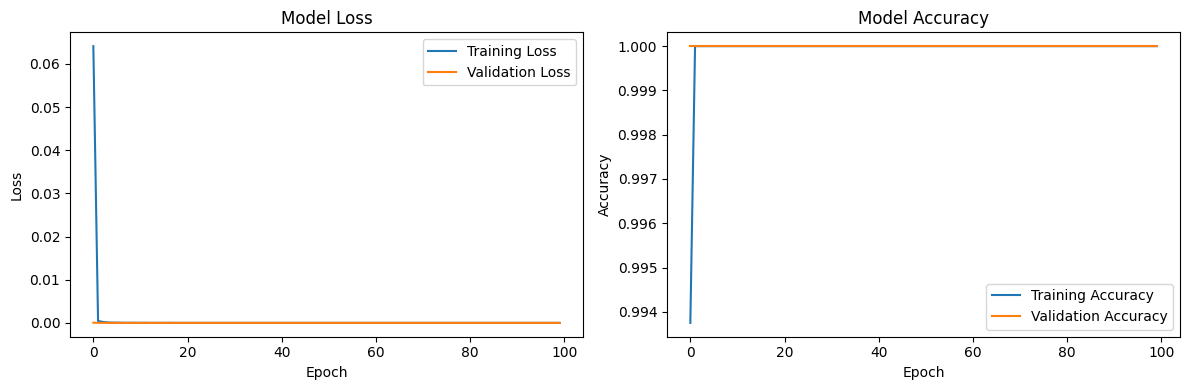

No early detection. Probability: 0.0000
ALERT: Potential Parkinson's detected 5 seconds early!
Probability: 1.0000
SOS Alert Sent: Emergency services notified.
No early detection. Probability: 0.0000
No early detection. Probability: 0.0000
ALERT: Potential Parkinson's detected 5 seconds early!
Probability: 1.0000
SOS Alert Sent: Emergency services notified.
No early detection. Probability: 0.0000
ALERT: Potential Parkinson's detected 5 seconds early!
Probability: 1.0000
SOS Alert Sent: Emergency services notified.
No early detection. Probability: 0.0000
No early detection. Probability: 0.0000
ALERT: Potential Parkinson's detected 5 seconds early!
Probability: 1.0000
SOS Alert Sent: Emergency services notified.

Validation Results:
Correct Early Detections: 4
False Positives: 0
False Negatives: 2
Detection Rate: 0.6667

Testing with synthetic Parkinson's input:
ALERT: Potential Parkinson's detected 5 seconds early!
Probability: 1.0000
SOS Alert Sent: Emergency services notified.
Expecte

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load and Prepare Data
df = pd.read_csv('/content/drive/MyDrive/Hackathon2.0/parkinsons_dataset3.csv')  # Assuming the data is saved from previous step

# Reshape data: (samples, time_steps, features)
time_steps = 10
n_features = 7  # EMG, Ax, Ay, Az, Gx, Gy, Gz
n_samples = len(df)
X = df.drop('Label', axis=1).values.reshape(n_samples, time_steps, n_features)
y = df['Label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 2. Build LSTM Model
def build_model():
    model = Sequential([
        LSTM(128, input_shape=(time_steps, n_features), return_sequences=True),
        Dropout(0.4),
        LSTM(64),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. Train Model
model = build_model()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 5. Early Detection and SOS Function
def predict_parkinsons_early(new_data, threshold=0.7, time_window=5):
    """
    new_data: array of shape (time_steps, 7) [EMG, Ax, Ay, Az, Gx, Gy, Gz]
    threshold: probability threshold for early detection
    time_window: seconds before visible effects (5-30)
    """
    new_data_scaled = scaler.transform(new_data)
    new_data_reshaped = new_data_scaled.reshape(1, time_steps, n_features)
    prediction_prob = model.predict(new_data_reshaped, verbose=0)[0][0]

    if prediction_prob > threshold:
        print(f"ALERT: Potential Parkinson's detected {time_window} seconds early!")
        print(f"Probability: {prediction_prob:.4f}")
        send_sos_alert()
        return True, prediction_prob
    else:
        print(f"No early detection. Probability: {prediction_prob:.4f}")
        return False, prediction_prob

def send_sos_alert():
    print("SOS Alert Sent: Emergency services notified.")

# 6. Simulate Real-time Prediction
sample_idx = 0
sample_data = X_test[sample_idx]
true_label = y_test[sample_idx]

detected, prob = predict_parkinsons_early(sample_data, threshold=0.7, time_window=5)
label_text = "Parkinson's" if true_label == 1 else "No Parkinson's"
print(f"True Label: {label_text}")

# 7. Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 8. Batch Prediction for Validation
def validate_early_detection(X_data, y_data, threshold=0.7, time_window=5):
    correct_detections = 0
    false_positives = 0
    false_negatives = 0

    for i in range(len(X_data)):
        detected, prob = predict_parkinsons_early(X_data[i], threshold, time_window)
        true_label = y_data[i]

        if detected and true_label == 1:
            correct_detections += 1
        elif detected and true_label == 0:
            false_positives += 1
        elif not detected and true_label == 1:
            false_negatives += 1

    print("\nValidation Results:")
    print(f"Correct Early Detections: {correct_detections}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    detection_rate = correct_detections / (correct_detections + false_negatives) if (correct_detections + false_negatives) > 0 else 0
    print(f"Detection Rate: {detection_rate:.4f}")

validate_early_detection(X_test[:10], y_test[:10])

# 9. Validation with Specific Input for Positive Detection
parkinsons_input = np.array([
    [200, 0.3, -0.2, 0.4, 5.0, -6.0, 7.0],
    [210, 0.4, -0.3, 0.5, 6.0, -5.0, 8.0],
    [205, 0.5, -0.4, 0.6, 7.0, -4.0, 9.0],
    [220, 0.6, -0.5, 0.7, 8.0, -3.0, 10.0],
    [215, 0.5, -0.6, 0.8, 9.0, -2.0, 11.0],
    [225, 0.4, -0.7, 0.9, 10.0, -1.0, 12.0],
    [230, 0.3, -0.8, 1.0, 11.0, 0.0, 13.0],
    [235, 0.2, -0.9, 1.1, 12.0, 1.0, 14.0],
    [240, 0.1, -1.0, 1.2, 13.0, 2.0, 15.0],
    [245, 0.0, -1.1, 1.3, 14.0, 3.0, 16.0]
])

print("\nTesting with synthetic Parkinson's input:")
detected, prob = predict_parkinsons_early(parkinsons_input, threshold=0.7, time_window=5)
print(f"Expected Outcome: Parkinson's should be detected")

# 10. User Input Testing Function
def test_with_user_input():
    print("\n=== User Input Testing Mode ===")
    print("Enter 10 sets of sensor readings (EMG, Ax, Ay, Az, Gx, Gy, Gz)")
    print("Format: space-separated values (e.g., '200 0.3 -0.2 0.4 5.0 -6.0 7.0')")
    print("Enter 'quit' to exit")

    user_data = []

    while len(user_data) < time_steps:
        try:
            user_input = input(f"Reading {len(user_data) + 1}/{time_steps}: ")

            if user_input.lower() == 'quit':
                print("Exiting user input mode...")
                return

            # Split and convert input to float
            values = [float(x) for x in user_input.split()]

            # Verify correct number of features
            if len(values) != n_features:
                print(f"Error: Please enter exactly {n_features} values (EMG, Ax, Ay, Az, Gx, Gy, Gz)")
                continue

            user_data.append(values)

            # When we have enough readings, make prediction
            if len(user_data) == time_steps:
                user_array = np.array(user_data)
                print("\nProcessing your input...")
                detected, prob = predict_parkinsons_early(user_array, threshold=0.7, time_window=5)
                user_data = []  # Reset for next set of readings

        except ValueError:
            print("Error: Please enter valid numeric values separated by spaces")
            continue
        except Exception as e:
            print(f"An error occurred: {e}")
            continue

# Run the user input testing
if __name__ == "__main__":
    # Run all previous steps first
    # [Assuming the model is trained and variables are available]

    # Start user input testing
    test_with_user_input()

#Muscle Fatigue

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your file path)
dataset_path = "/content/drive/MyDrive/Hackathon2.0/emg_muscle_fatigue_dataset (1).csv"  # Update this
df = pd.read_csv(dataset_path)

# Display dataset overview
print("Dataset Overview:")
print(df.head())
print("\nLabel Distribution:")
print(df['Label'].value_counts())

# Preprocessing
# Features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Encode Muscle_Group
le = LabelEncoder()
X['Muscle_Group'] = le.fit_transform(X['Muscle_Group'])

# Split into train and test sets (stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['EMG_Amplitude', 'Median_Frequency', 'Mean_Frequency', 'RMS', 'Time_Since_Start']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score to balance precision and recall
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Muscle Fatigue Detection')
plt.show()

# Function to predict fatigue
def predict_fatigue(emg_amplitude, median_freq, mean_freq, rms, muscle_group, time_since_start):
    input_data = pd.DataFrame({
        'EMG_Amplitude': [emg_amplitude],
        'Median_Frequency': [median_freq],
        'Mean_Frequency': [mean_freq],
        'RMS': [rms],
        'Muscle_Group': [le.transform([muscle_group])[0]],
        'Time_Since_Start': [time_since_start]
    })
    input_scaled = input_data.copy()
    input_scaled[numerical_cols] = scaler.transform(input_data[numerical_cols])
    prediction = best_model.predict(input_scaled)[0]
    probability = best_model.predict_proba(input_scaled)[0][1]
    return {
        'Prediction': "Fatigued" if prediction == 1 else "Normal",
        'Fatigue Probability': probability
    }

# Get user input for real-time prediction
def get_user_input():
    print("\nEnter the following EMG sensor values to check for muscle fatigue:")
    while True:
        try:
            emg_amplitude = float(input("Enter EMG Amplitude (mV, e.g., 0.2 to 1.5): "))
            median_freq = float(input("Enter Median Frequency (Hz, e.g., 20 to 150): "))
            mean_freq = float(input("Enter Mean Frequency (Hz, e.g., 20 to 150): "))
            rms = float(input("Enter RMS (mV, e.g., 0.1 to 1.0): "))
            muscle_group = input("Enter Muscle Group (Biceps, Quadriceps, Gastrocnemius): ").capitalize()
            if muscle_group not in le.classes_:
                raise ValueError("Invalid muscle group!")
            time_since_start = float(input("Enter Time Since Start (seconds, e.g., 0 to 900): "))
            return emg_amplitude, median_freq, mean_freq, rms, muscle_group, time_since_start
        except ValueError as e:
            print(f"Invalid input! {e}. Please try again.")

# Main loop for user interaction
while True:
    emg_amplitude, median_freq, mean_freq, rms, muscle_group, time_since_start = get_user_input()
    result = predict_fatigue(emg_amplitude, median_freq, mean_freq, rms, muscle_group, time_since_start)
    print(f"\nPrediction for {muscle_group}:")
    print(f"State: {result['Prediction']}")
    print(f"Fatigue Probability: {result['Fatigue Probability']:.2%}")

    continue_choice = input("\nTest another set of values? (yes/no): ").lower()
    if continue_choice != 'yes':
        print("Exiting program.")
        break

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6903 - loss: 0.5850 - val_accuracy: 0.7258 - val_loss: 0.5355
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7275 - loss: 0.5358 - val_accuracy: 0.7325 - val_loss: 0.5388
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7468 - loss: 0.5301 - val_accuracy: 0.7325 - val_loss: 0.5353
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7621 - loss: 0.4988 - val_accuracy: 0.7175 - val_loss: 0.5396
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7624 - loss: 0.4960 - val_accuracy: 0.7242 - val_loss: 0.5418
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7622 - loss: 0.4904 - val_accuracy: 0.7267 - val_loss: 0.5622
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7938 - loss: 0.4525 - val_accuracy: 0.7242 - val_loss: 0.5630
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7838 - loss: 0.4519 - 

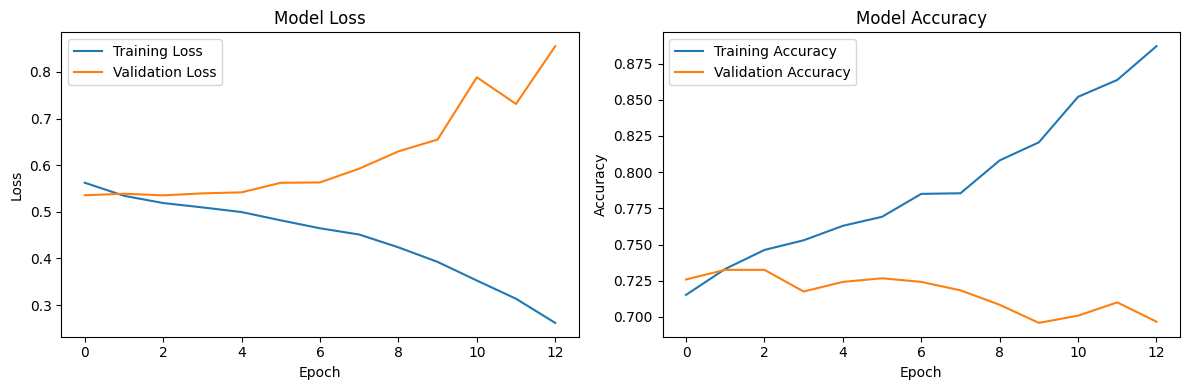

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load and Prepare Data
df = pd.read_csv('/content/parkinsons_dataset3 (1).csv')

# Reshape data: (samples, time_steps, features)
time_steps = 10
n_features = 7  # EMG, Ax, Ay, Az, Gx, Gy, Gz
n_samples = len(df)
X = df.drop('Label', axis=1).values.reshape(n_samples, time_steps, n_features)
y = df['Label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape)

# **Introduce Noise (Gaussian Noise)**
noise_std = 4.2# Adjust this value to control noise level
X_scaled_noisy = X_scaled + np.random.normal(0, noise_std, X_scaled.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_noisy, y, test_size=0.2, random_state=42
)

# 2. Build LSTM Model
def build_model():
    model = Sequential([
        LSTM(128, input_shape=(time_steps, n_features), return_sequences=True),
        Dropout(0.4),
        LSTM(64),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. Train Model
model = build_model()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 5. Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7144 - loss: 0.5702 - val_accuracy: 0.7558 - val_loss: 0.5080
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7678 - loss: 0.5044 - val_accuracy: 0.7492 - val_loss: 0.5035
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7660 - loss: 0.5018 - val_accuracy: 0.7525 - val_loss: 0.5081
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7791 - loss: 0.4789 - val_accuracy: 0.7550 - val_loss: 0.5030
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7677 - loss: 0.4872 - val_accuracy: 0.7533 - val_loss: 0.5087
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7815 - loss: 0.4637 - val_accuracy: 0.7533 - val_loss: 0.5105
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7992 - loss: 0.4454 - val_accuracy: 0.7325 - val_loss: 0.5196
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8119 - loss: 0.4284 - val_accuracy

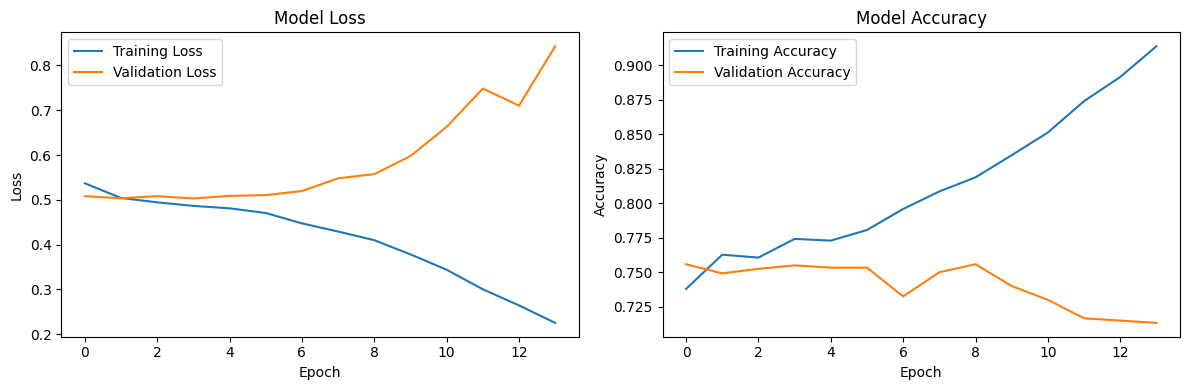

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load and Prepare Data
df = pd.read_csv('/content/parkinsons_dataset3 (1).csv')

# Reshape data: (samples, time_steps, features)
time_steps = 10
n_features = 7  # EMG, Ax, Ay, Az, Gx, Gy, Gz
n_samples = len(df)
X = df.drop('Label', axis=1).values.reshape(n_samples, time_steps, n_features)
y = df['Label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape)

# **Introduce Noise (Gaussian Noise)**
noise_std = 3.8# Adjust this value to control noise level
X_scaled_noisy = X_scaled + np.random.normal(0, noise_std, X_scaled.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_noisy, y, test_size=0.2, random_state=42
)

# 2. Build LSTM Model
def build_model():
    model = Sequential([
        LSTM(128, input_shape=(time_steps, n_features), return_sequences=True),
        Dropout(0.4),
        LSTM(64),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. Train Model
model = build_model()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 5. Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7441 - loss: 0.5407 - val_accuracy: 0.8008 - val_loss: 0.4297
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7905 - loss: 0.4530 - val_accuracy: 0.7883 - val_loss: 0.4420
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8043 - loss: 0.4323 - val_accuracy: 0.8133 - val_loss: 0.4230
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8097 - loss: 0.4230 - val_accuracy: 0.8083 - val_loss: 0.4186
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8200 - loss: 0.4136 - val_accuracy: 0.8058 - val_loss: 0.4286
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8276 - loss: 0.3950 - val_accuracy: 0.8125 - val_loss: 0.4065
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8378 - loss: 0.3765 - val_accuracy: 0.8058 - val_loss: 0.4209
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8313 - loss: 0.3803 - val_accuracy

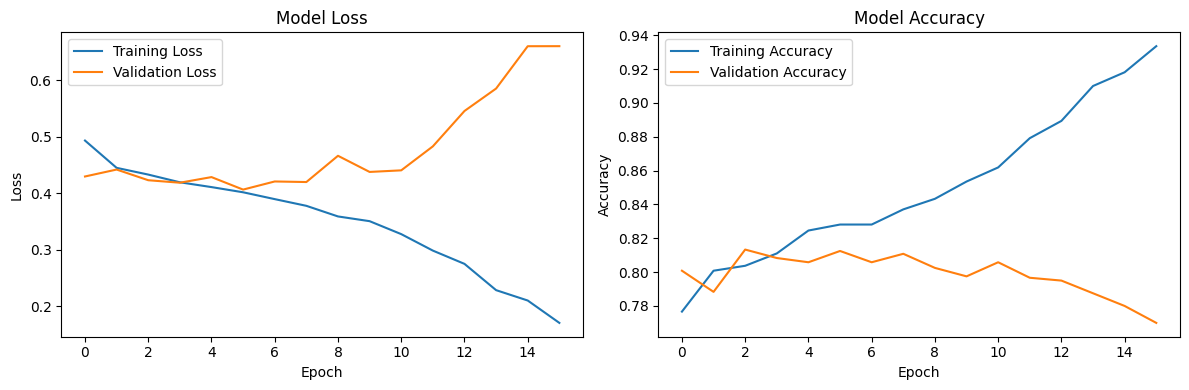

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load and Prepare Data
df = pd.read_csv('/content/parkinsons_dataset3 (1).csv')

# Reshape data: (samples, time_steps, features)
time_steps = 10
n_features = 7  # EMG, Ax, Ay, Az, Gx, Gy, Gz
n_samples = len(df)
X = df.drop('Label', axis=1).values.reshape(n_samples, time_steps, n_features)
y = df['Label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape)

# **Introduce Noise (Gaussian Noise)**
noise_std = 3.2# Adjust this value to control noise level
X_scaled_noisy = X_scaled + np.random.normal(0, noise_std, X_scaled.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_noisy, y, test_size=0.2, random_state=42
)

# 2. Build LSTM Model
def build_model():
    model = Sequential([
        LSTM(128, input_shape=(time_steps, n_features), return_sequences=True),
        Dropout(0.4),
        LSTM(64),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. Train Model
model = build_model()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 5. Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
